based on the following notebooks:
https://www.kaggle.com/code/eunicemok/recommendation-engine-that-combats-polarization

In the notebook two datasets were used:
1. CI&T whichi includes for each user with articles he interacted with - 'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW'
2. All the News - which includes information about difference news articles and their source.

In the notebook they used the source of the article (the website it was publised on) to determain the political view of the article (left, neutral, right). Then a model was trained (TD-IDF) based on the content of the articles in order to learn to classify the view of each article.
Using this model, we can classify the views of all the articles the user interacted with and that way see what his general views are.

In [1]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns


### Load Data:

In [2]:
# update releavent path
path = 'C:/Users/gony/Downloads/CI&T.zip'

In [3]:
dfs = {}
with ZipFile(path, "r") as f:
    for name in f.namelist():
        with f.open(name) as zd:
            print(name)
            df = pd.read_csv(zd, encoding='utf8')
            dfs[name] = df
users_intrcs = dfs['users_interactions.csv']
shared_articles = dfs['shared_articles.csv']

shared_articles.csv
users_interactions.csv


In [4]:
# update releavent path
path = 'C:/Users/gony/Downloads/All_the_News.zip'

In [5]:
dfs = pd.DataFrame()
with ZipFile(path, "r") as f:
    for name in f.namelist():
        if name == 'articles2.csv':
            continue
        with f.open(name) as zd:
            print(name)
            df = pd.read_csv(zd, index_col=False)
            dfs = pd.concat([dfs, df], ignore_index=True)
            del [df]
# articles = pd.concat([dfs['articles1.csv'], dfs['articles3.csv']], ignore_index=True)
articles = dfs

articles1.csv
articles3.csv


In [6]:
users_intrcs.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [7]:
users_intrcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    72312 non-null  int64 
 1   eventType    72312 non-null  object
 2   contentId    72312 non-null  int64 
 3   personId     72312 non-null  int64 
 4   sessionId    72312 non-null  int64 
 5   userAgent    56918 non-null  object
 6   userRegion   56907 non-null  object
 7   userCountry  56918 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.3+ MB


In [8]:
np.unique(users_intrcs['eventType'].values)

array(['BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW'],
      dtype=object)

In [9]:
shared_articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [10]:
shared_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        3122 non-null   int64 
 1   eventType        3122 non-null   object
 2   contentId        3122 non-null   int64 
 3   authorPersonId   3122 non-null   int64 
 4   authorSessionId  3122 non-null   int64 
 5   authorUserAgent  680 non-null    object
 6   authorRegion     680 non-null    object
 7   authorCountry    680 non-null    object
 8   contentType      3122 non-null   object
 9   url              3122 non-null   object
 10  title            3122 non-null   object
 11  text             3122 non-null   object
 12  lang             3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 207.4+ KB


In [11]:
np.unique(shared_articles['eventType'].values)

array(['CONTENT REMOVED', 'CONTENT SHARED'], dtype=object)

In [12]:
articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [13]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92571 entries, 0 to 92570
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   92571 non-null  int64  
 1   id           92571 non-null  int64  
 2   title        92570 non-null  object 
 3   publication  92571 non-null  object 
 4   author       85293 non-null  object 
 5   date         92556 non-null  object 
 6   year         92556 non-null  float64
 7   month        92556 non-null  float64
 8   url          42571 non-null  object 
 9   content      92571 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 4.9+ MB


## Analysis:

In [14]:
articles = articles.rename(columns = {'Unnamed: 0': 'number'})


In [15]:
for column in articles:
    Y = articles['publication']
Y.head()

0    New York Times
1    New York Times
2    New York Times
3    New York Times
4    New York Times
Name: publication, dtype: object

In [16]:
np.unique(Y.values)

array(['Atlantic', 'Breitbart', 'Business Insider', 'CNN', 'Guardian',
       'NPR', 'New York Times', 'Reuters', 'Vox', 'Washington Post'],
      dtype=object)

Categorizing article based on the publisher:

In [17]:
for ind in range(len(Y)-1):
  if Y[ind] =='New York Times' or Y[ind] == 'CNN' or Y[ind] == 'Buzzfeed News' or Y[ind] =='Business Insider' or Y[ind] =='the Atlantic' or Y[ind] =='Talking Points Memo' or Y[ind] =='the Guardian' or Y[ind] == 'Vox' or Y[ind] =='Washington Post':
    articles.at[ind,'Lean'] = 'Left'
    

  elif Y[ind] == 'NPR' or Y[ind] == 'Reuters':
    articles.at[ind,'Lean'] = 'Neutral'

  else:
    articles.at[ind,'Lean'] = 'Right'

In [18]:
target = articles.groupby(["Lean"]).count()
percent_target = (target/len(articles))*100
percent_target

,number,id,title,publication,author,date,year,month,url,content
Lean,,,,,,,,,,
Left,45.487248,45.487248,45.487248,45.487248,38.635210,45.487248,45.487248,45.487248,17.348846,45.487248
Neutral,24.523879,24.523879,24.522799,24.523879,24.158754,24.523879,24.523879,24.523879,24.523879,24.523879
Right,29.987793,29.987793,29.987793,29.987793,29.342883,29.971589,29.971589,29.971589,4.113599,29.987793


<function matplotlib.pyplot.show(*args, **kw)>

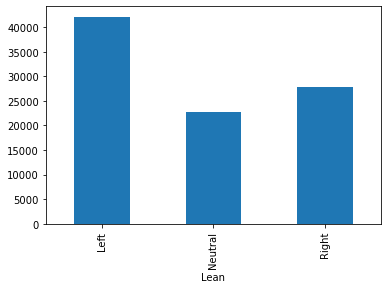

In [19]:
articles.groupby(["Lean"]).Lean.count().plot.bar(ylim = 0)
plt.show

Training model to clasify the lean:

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.multiclass import OneVsRestClassifier   #1vs1 & 1vsRest Classifiers
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import gc

In [21]:
# take random sample of articles
sample = articles.sample(n= 25000, random_state = 1)
y = sample['Lean']
X = sample['content']

In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
df_tfIdf = vectorizer.fit_transform(X.values)
# print(vectorizer.get_feature_names()[:10])
  
X_train, X_val, y_train, y_val = train_test_split(df_tfIdf, y, test_size=0.10, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape

model = PassiveAggressiveClassifier(max_iter=10000, random_state=1,tol=1e-3).fit(X_train, y_train)
y_pred = model.predict(X_val)

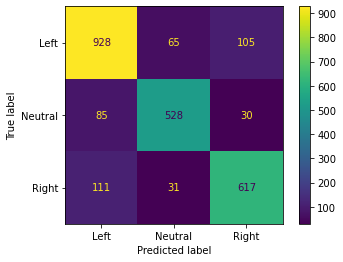

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Left', 'Neutral', 'Right'])

cm_display.plot()
plt.show()

In [24]:
print('accuracy of model: ', sum(y_val == y_pred)/len(y_val))

accuracy of model:  0.8292


In [25]:
x_test = shared_articles['text']
y_test = model.predict(vectorizer.transform(x_test.values))

In [26]:
shared_articles['Lean'] = y_test

<function matplotlib.pyplot.show(*args, **kw)>

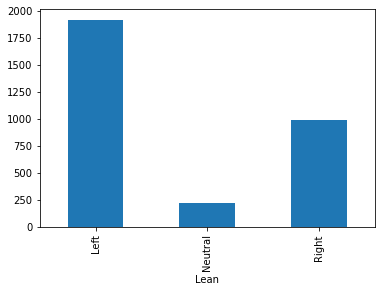

In [27]:
shared_articles.groupby(["Lean"]).Lean.count().plot.bar(ylim = 0)
plt.show

In [28]:
df = users_intrcs.copy()

Can someone check my merge logic? (always confuses me)

In [29]:
df = pd.merge(df, shared_articles, left_on='contentId', right_on='contentId', how='inner')

In [30]:
groupby_user = df.groupby('personId', as_index=False).agg({'Lean':lambda x: list(x), 'eventType_x':lambda x: list(x)})

In [31]:
groupby_user.head()

,personId,Lean,eventType_x
0,-9223121837663643404,"[Left, Left, Left, Left, Neutral, Left, Right,...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE..."
1,-9212075797126931087,"[Left, Left, Right, Right, Right, Right, Neutr...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIKE, VIE..."
2,-9207251133131336884,"[Right, Right, Right, Right, Right, Right, Rig...","[VIEW, LIKE, VIEW, VIEW, LIKE, LIKE, VIEW, VIE..."
3,-9199575329909162940,"[Left, Left, Left, Left, Right, Left, Left, Ri...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIK..."
4,-9196668942822132778,"[Right, Left, Left, Left, Left, Right, Right, ...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE..."


In [32]:
temp = groupby_user['Lean']

for i in range(len(temp)):
    leans = temp[i]
    left, right, neutral = 0, 0, 0
    for x in leans:
        if x == 'Left':
            left += 1
        elif x == 'Right':
            right += 1
        else:
            neutral += 1
    groupby_user.at[i, 'Left'] = left/len(leans)
    groupby_user.at[i, 'Neutral'] = neutral/len(leans)
    groupby_user.at[i, 'Right'] = right/len(leans)


In [33]:
groupby_user.head()

,personId,Lean,eventType_x,Left,Neutral,Right
0,-9223121837663643404,"[Left, Left, Left, Left, Neutral, Left, Right,...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.584615,0.046154,0.369231
1,-9212075797126931087,"[Left, Left, Right, Right, Right, Right, Neutr...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIKE, VIE...",0.333333,0.222222,0.444444
2,-9207251133131336884,"[Right, Right, Right, Right, Right, Right, Rig...","[VIEW, LIKE, VIEW, VIEW, LIKE, LIKE, VIEW, VIE...",0.214286,0.071429,0.714286
3,-9199575329909162940,"[Left, Left, Left, Left, Right, Left, Left, Ri...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIK...",0.733333,0.000000,0.266667
4,-9196668942822132778,"[Right, Left, Left, Left, Left, Right, Right, ...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.500000,0.000000,0.500000


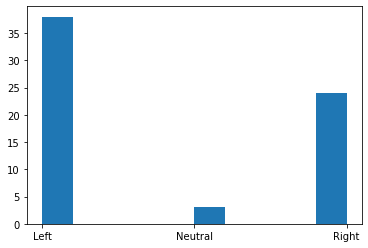

In [34]:
plt.hist(groupby_user.iloc[0].Lean)
plt.show()

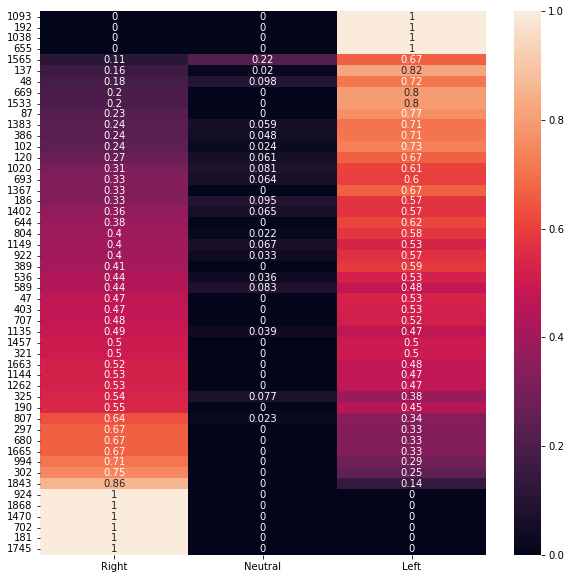

In [35]:
lean_sample = groupby_user.sample(n= 50, random_state = 1)
lean_sample = lean_sample.sort_values('Right')
plt.figure(figsize=(10,10))
sns.heatmap(lean_sample[['Right', 'Neutral', 'Left']], annot=True)
plt.show()

In the heatmap above we can see that most users have a political view in which most of the news articles they interact with are from that point of view. It is incoraging to see that we do have users that have around equal amount of articles from different views, but we can see see echo chambers forming, wtih users who only interact with one type of political view.

In [36]:
groupby_user[groupby_user['Left']==1].count(), groupby_user[groupby_user['Right']==1].count()

(personId       280
 Lean           280
 eventType_x    280
 Left           280
 Neutral        280
 Right          280
 dtype: int64,
 personId       182
 Lean           182
 eventType_x    182
 Left           182
 Neutral        182
 Right          182
 dtype: int64)

In [37]:
left, right, neutral = [], [], []
for i, row in groupby_user.iterrows():
    if row['Left'] >=0.6:
        left.append(row['Left'])
    elif row['Right'] >=0.6:
        right.append(row['Right'])
    else:
        neutral.append(row['Neutral'])

In [38]:
len(left), len(right), len(neutral)

(903, 442, 550)

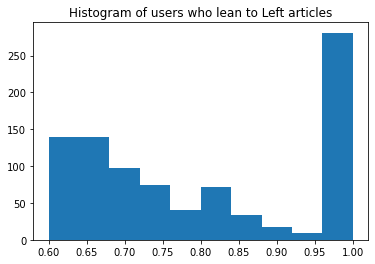

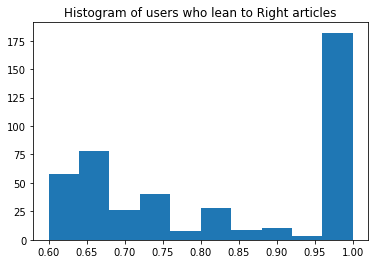

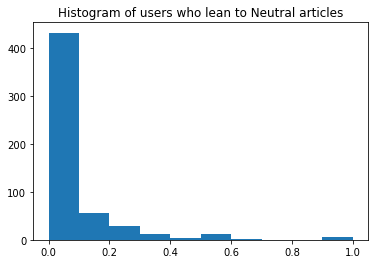

In [39]:
plt.hist(left)
plt.title('Histogram of users who lean to Left articles')
plt.show()
plt.hist(right)
plt.title('Histogram of users who lean to Right articles')
plt.show()
plt.hist(neutral)
plt.title('Histogram of users who lean to Neutral articles')
plt.show()

In [40]:
events = ['BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW']
bookmark = np.zeros(groupby_user.shape[0])
comment = np.zeros(groupby_user.shape[0])
follow = np.zeros(groupby_user.shape[0])
like = np.zeros(groupby_user.shape[0])
view = np.zeros(groupby_user.shape[0])

from collections import Counter
for i, row in groupby_user.iterrows():
    temp = dict(Counter(row['eventType_x']))
    total = len(row['eventType_x'])
    result = {key: round(value / total, 4) for key, value in temp.items()}
    keys = result.keys()
    if 'BOOKMARK' in keys:
        bookmark[i] = result['BOOKMARK']
    if 'COMMENT CREATED' in keys:
        comment[i] = result['COMMENT CREATED']
    if 'FOLLOW' in keys:
        follow[i] = result['FOLLOW']
    if 'LIKE' in keys:
        like[i] = result['LIKE']
    if 'VIEW' in keys:
        view[i] = result['VIEW']
groupby_user['BOOKMARK'] = bookmark
groupby_user['COMMENT CREATED'] = comment
groupby_user['FOLLOW'] = follow
groupby_user['LIKE'] = like
groupby_user['VIEW'] = view

In [41]:
groupby_user.head()

,personId,Lean,eventType_x,Left,Neutral,Right,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW
0,-9223121837663643404,"[Left, Left, Left, Left, Neutral, Left, Right,...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.584615,0.046154,0.369231,0.0000,0.0,0.0,0.0154,0.9846
1,-9212075797126931087,"[Left, Left, Right, Right, Right, Right, Neutr...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIKE, VIE...",0.333333,0.222222,0.444444,0.0000,0.0,0.0,0.1111,0.8889
2,-9207251133131336884,"[Right, Right, Right, Right, Right, Right, Rig...","[VIEW, LIKE, VIEW, VIEW, LIKE, LIKE, VIEW, VIE...",0.214286,0.071429,0.714286,0.0714,0.0,0.0,0.3571,0.5714
3,-9199575329909162940,"[Left, Left, Left, Left, Right, Left, Left, Ri...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIK...",0.733333,0.000000,0.266667,0.0000,0.0,0.0,0.0667,0.9333
4,-9196668942822132778,"[Right, Left, Left, Left, Left, Right, Right, ...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.500000,0.000000,0.500000,0.0000,0.0,0.0,0.0000,1.0000


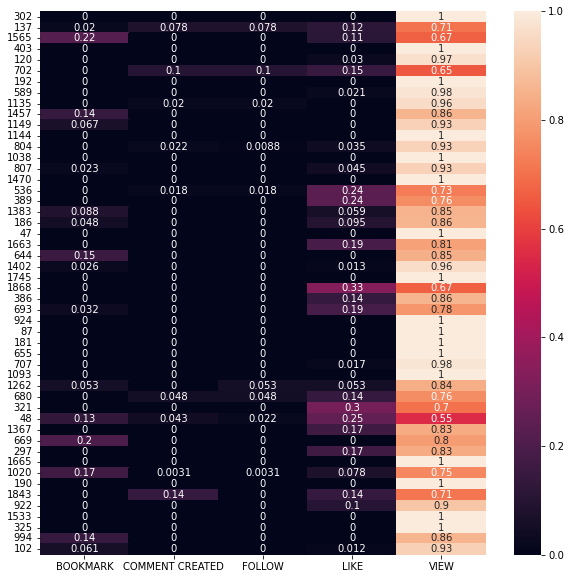

In [42]:
lean_sample = groupby_user.sample(n= 50, random_state = 1)
# lean_sample = lean_sample.sort_values('Right')
plt.figure(figsize=(10,10))
sns.heatmap(lean_sample[['BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW']], annot=True)
plt.show()

In [43]:
groupby_user.head()

,personId,Lean,eventType_x,Left,Neutral,Right,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW
0,-9223121837663643404,"[Left, Left, Left, Left, Neutral, Left, Right,...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.584615,0.046154,0.369231,0.0000,0.0,0.0,0.0154,0.9846
1,-9212075797126931087,"[Left, Left, Right, Right, Right, Right, Neutr...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIKE, VIE...",0.333333,0.222222,0.444444,0.0000,0.0,0.0,0.1111,0.8889
2,-9207251133131336884,"[Right, Right, Right, Right, Right, Right, Rig...","[VIEW, LIKE, VIEW, VIEW, LIKE, LIKE, VIEW, VIE...",0.214286,0.071429,0.714286,0.0714,0.0,0.0,0.3571,0.5714
3,-9199575329909162940,"[Left, Left, Left, Left, Right, Left, Left, Ri...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, LIK...",0.733333,0.000000,0.266667,0.0000,0.0,0.0,0.0667,0.9333
4,-9196668942822132778,"[Right, Left, Left, Left, Left, Right, Right, ...","[VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIEW, VIE...",0.500000,0.000000,0.500000,0.0000,0.0,0.0,0.0000,1.0000


In [44]:
bookmark =[[] for _ in range(groupby_user.shape[0])]
comment = [[] for _ in range(groupby_user.shape[0])]
follow = [[] for _ in range(groupby_user.shape[0])]
like = [[] for _ in range(groupby_user.shape[0])]
view = [[] for _ in range(groupby_user.shape[0])]
for i, row in groupby_user.iterrows():
    if row['VIEW'] != 1:
        lean = row['Lean']
        events = row['eventType_x']
        for l, e in zip(lean, events):
            if e == 'BOOKMARK':
                bookmark[i].append(l)
            if e == 'COMMENT CREATED':
                comment[i].append(l)
            if e == 'FOLLOW':
                follow[i].append(l)
            if e == 'LIKE':
                like[i].append(l)
            if e == 'VIEW':
                view[i].append(l)

groupby_user['BOOKMARK_Lean'] = bookmark
groupby_user['COMMENT_Lean'] = comment
groupby_user['FOLLOW_Lean'] = follow
groupby_user['LIKE_Lean'] = like
groupby_user['VIEW_Lean'] = view


Examined Liked articles:

In [45]:
liked_df = groupby_user[(groupby_user['LIKE'] != 0) & (groupby_user["VIEW"]!= 1)]
liked_df = liked_df[['personId', 'Left', 'Neutral', 'Right', 'LIKE_Lean']].reset_index()

temp = liked_df['LIKE_Lean']

for i in range(len(temp)):
    leans = temp[i]
    left, right, neutral = 0, 0, 0
    for x in leans:
        if x == 'Left':
            left += 1
        elif x == 'Right':
            right += 1
        else:
            neutral += 1
    liked_df.at[i, 'LIKED_Left'] = left/len(leans)
    liked_df.at[i, 'LIKED_Neutral'] = neutral/len(leans)
    liked_df.at[i, 'LIKED_Right'] = right/len(leans)

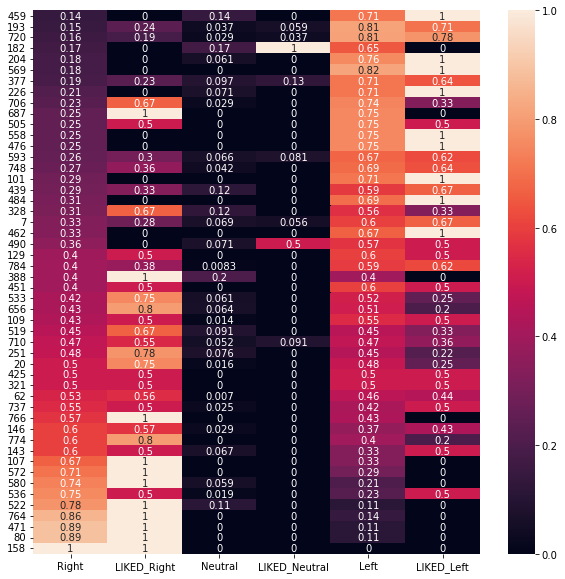

In [52]:
like_sample = liked_df.sample(n= 50, random_state = 2)
like_sample = like_sample.sort_values('Right')
plt.figure(figsize=(10,10))
sns.heatmap(like_sample[['Right', 'LIKED_Right', 'Neutral', 'LIKED_Neutral', 'Left', 'LIKED_Left']], annot=True)
plt.show()

Examine commented articles:

In [59]:
comment_df = groupby_user[(groupby_user['COMMENT CREATED'] != 0) & (groupby_user["VIEW"]!= 1)]
comment_df = comment_df[['personId', 'Left', 'Neutral', 'Right', 'COMMENT_Lean']].reset_index()

temp = comment_df['COMMENT_Lean']

for i in range(len(temp)):
    leans = temp[i]
    left, right, neutral = 0, 0, 0
    for x in leans:
        if x == 'Left':
            left += 1
        elif x == 'Right':
            right += 1
        else:
            neutral += 1
    comment_df.at[i, 'COMMENT_Left'] = left/len(leans)
    comment_df.at[i, 'COMMENT_Neutral'] = neutral/len(leans)
    comment_df.at[i, 'COMMENT_Right'] = right/len(leans)

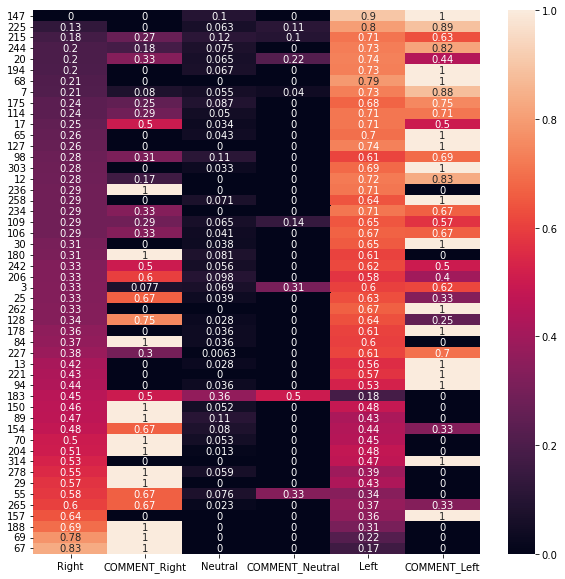

In [60]:
comment_sample = comment_df.sample(n= 50, random_state = 2)
comment_sample = comment_sample.sort_values('Right')
plt.figure(figsize=(10,10))
sns.heatmap(comment_sample[['Right', 'COMMENT_Right', 'Neutral', 'COMMENT_Neutral', 'Left', 'COMMENT_Left']], annot=True)
plt.show()